In [32]:
import gensim
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot,model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle
import pandas as pd
import numpy as np

### Parameters

In [33]:
filename = 'test.txt'
#filename = 'en_US.blogs.txt'
#trainset_prefix = 'part001'
trainset_prefix = ''

IN_SEQ_LENGTH = 3
OUT_SEQ_LENGTH = 1
EMBEDDING_DIM = 64
HIDDEN_LAYER_1 = 1024
HIDDEN_LAYER_2 = 1024
MODEL_NAME = 'nn_3_in_2_lstm_1_out'

N_SAMPLES = 1000000
N_EPOCH = 4

In [34]:
META_EMPTY = '<<<!EMP!>>>'

### Load corpora

In [35]:
corpora = gensim.corpora.Dictionary.load('./data/'+filename+'.corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))
tmp = list(corpora.items())

Number of words in corpora: 14


### Set network configuration

In [36]:
model = Sequential()
model.add( Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=IN_SEQ_LENGTH) )
model.add( LSTM(HIDDEN_LAYER_1, return_sequences=True) )
model.add( LSTM(HIDDEN_LAYER_1, return_sequences=False) )

model.add( Dense(output_dim=vocab_size, activation='softmax') )

In [37]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_3 (Embedding)          (None, 3, 64)         896         embedding_input_3[0][0]          
____________________________________________________________________________________________________
lstm_5 (LSTM)                    (None, 3, 1024)       4460544     embedding_3[0][0]                
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (None, 1024)          8392704     lstm_5[0][0]                     
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 14)            14350       lstm_6[0][0]                     
Total params: 12868494
____________________________________________________________________

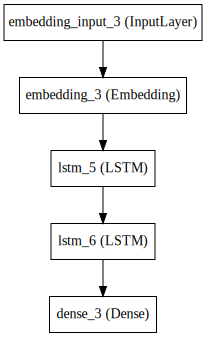

In [39]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [40]:
fname = './data/' + MODEL_NAME + '.json'
with open(fname, mode='w') as f:
    f.write(model.to_json())

### Load train set

In [41]:
print("Loading train set...")

Loading train set...


In [42]:
train_X = pd.read_csv('./data/' + filename + '.' + str(IN_SEQ_LENGTH) + '_in_' + str(OUT_SEQ_LENGTH) + '_out.train_X.csv')
train_Y = pd.read_csv('./data/' + filename + '.' + str(IN_SEQ_LENGTH) + '_in_' + str(OUT_SEQ_LENGTH) + '_out.train_Y.csv')

In [43]:
# Trancate dataset
N_SAMPLES = min(N_SAMPLES, train_X.shape[0])

train_X = train_X.loc[:N_SAMPLES,:]
train_Y = train_Y.loc[:N_SAMPLES,:]

In [44]:
print('Train set X, Y:')
print( train_X.shape, train_Y.shape )

Train set X, Y:
(39, 3) (39, 1)


### Train the network

In [45]:
checkname = './data/' + filename + '.' + MODEL_NAME + '.weights.hdf5'

checkpoint = ModelCheckpoint(checkname, monitor='acc', verbose=1, save_best_only=True, mode='max')

model.fit(train_X.as_matrix(), train_Y.as_matrix(), batch_size=N_SAMPLES, nb_epoch=N_EPOCH, callbacks=[checkpoint])

Epoch 1/4
Epoch 00000: acc improved from -inf to 0.07692, saving model to ./data/test.txt.nn_3_in_2_lstm_1_out.weights.hdf5
39/39 [==============================] - 1s - loss: 2.6393 - acc: 0.0769
Epoch 2/4
Epoch 00001: acc improved from 0.07692 to 0.84615, saving model to ./data/test.txt.nn_3_in_2_lstm_1_out.weights.hdf5
39/39 [==============================] - 1s - loss: 2.6097 - acc: 0.8462
Epoch 3/4
Epoch 00002: acc did not improve
39/39 [==============================] - 1s - loss: 2.5757 - acc: 0.7692
Epoch 4/4
Epoch 00003: acc did not improve
39/39 [==============================] - 1s - loss: 2.5310 - acc: 0.7692


#scores = model.evaluate(train_X, train_Y, verbose=0)
#print("Model Accuracy: %.2f%%" % (scores[1]*100))